# <center>+++ Project still in progres +++<center>

# Sentiment Analysis on Twitter Data

In this notebook I will use **Natural Language Processing (NLP)** techniques to analyze the twitter dataset **sentiment140**. The dataset consists of 1.6 million tweets, which are labeled as positive, neutral or negative regarding their sentiment. 

In the first part data preprocessing is conducted. In the second part the model is built using **Logistic Regression** and gets evaluated.

## 1. Data Preprocessing

In [1]:
# general
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from wordcloud import WordCloud
from PIL import Image
from collections import Counter

# nltk
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#%%time
columns = ['target', 'id', 'date', 'query_string', 'user', 'text']
df = pd.read_csv('trainingdata.csv', header=None, names=columns, encoding='latin1')
df = df[['target', 'text']]

In [3]:
decode_map = {0: 'negative', 2: 'neutral', 4: 'positive'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [4]:
#%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

In [5]:
df.head()

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.groupby(['target']).count()

,text
target,
negative,800000
positive,800000


Text(0.5, 1.0, 'Dataset labels distribution')

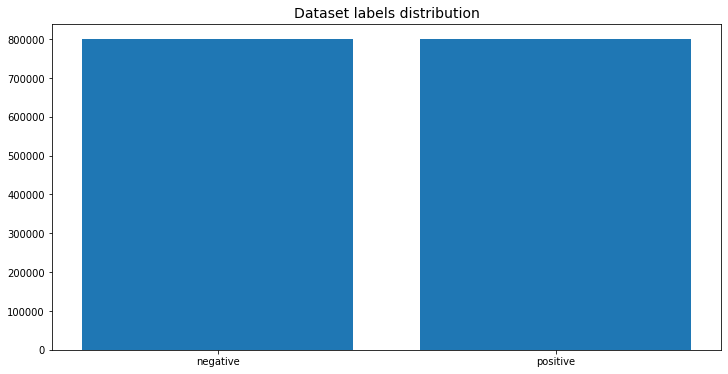

In [7]:
target_cnt = Counter(df.target)

plt.figure(figsize=(12,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset labels distribution', fontsize=14)

In [8]:
#%%time
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(df.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [9]:
#%%time

#Create matrices with word counts for neg and pos texts
neg_doc_matrix = vectorizer.transform(df[df.target == 'negative'].text)
pos_doc_matrix = vectorizer.transform(df[df.target == 'positive'].text)

#Create 2 lists with counts for each word in all neg and pos texts
neg_tf = np.sum(neg_doc_matrix, axis=0)
pos_tf = np.sum(pos_doc_matrix, axis=0)

#Convert neg and pos word count lists from from dim (1, 684358) to dim (684358,)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

#Combine two arrays from neg and pos word counts to dataframe and add words as headers
term_freq_df = pd.DataFrame([neg,pos], columns=vectorizer.get_feature_names()).transpose()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

term_freq_df.sort_values(by='total', ascending=False).iloc[0:10]

,negative,positive,total
to,18313.087611,14909.589299,33222.676910
the,14807.559187,15981.943395,30789.502582
you,8216.724733,16169.262228,24385.986961
my,13861.420232,9101.730210,22963.150442
it,11208.910798,10948.893801,22157.804599
and,10252.775087,10208.352781,20461.127868
is,10437.109927,8964.439197,19401.549123
for,7619.058685,9732.230293,17351.288977
in,8899.685730,7841.668162,16741.353892
me,8334.574838,6450.608309,14785.183147


Just out of curiosity let's have a look at the most frequent negative and positive words **before the preprocessing.**

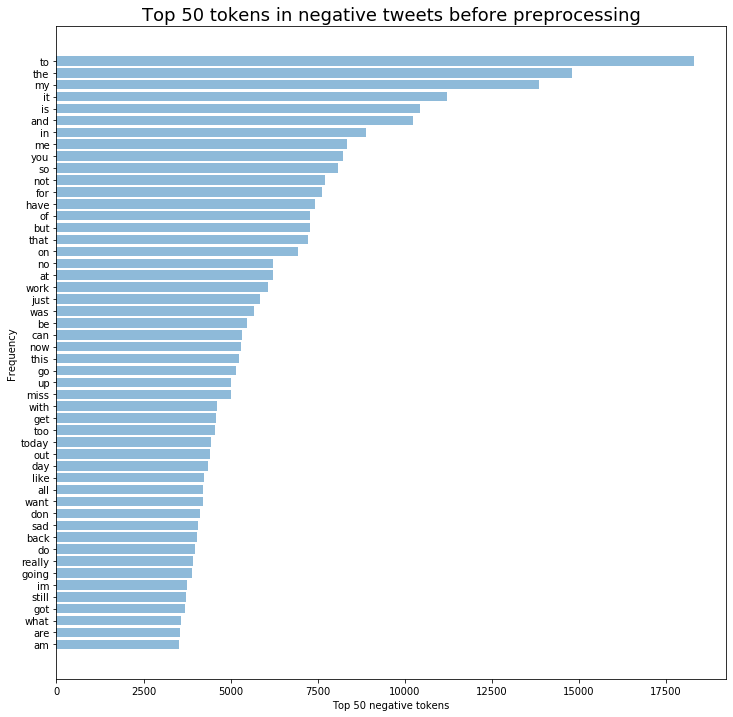

In [10]:
y_pos = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.yticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='horizontal')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets before preprocessing', fontsize=18)
plt.gca().invert_yaxis()

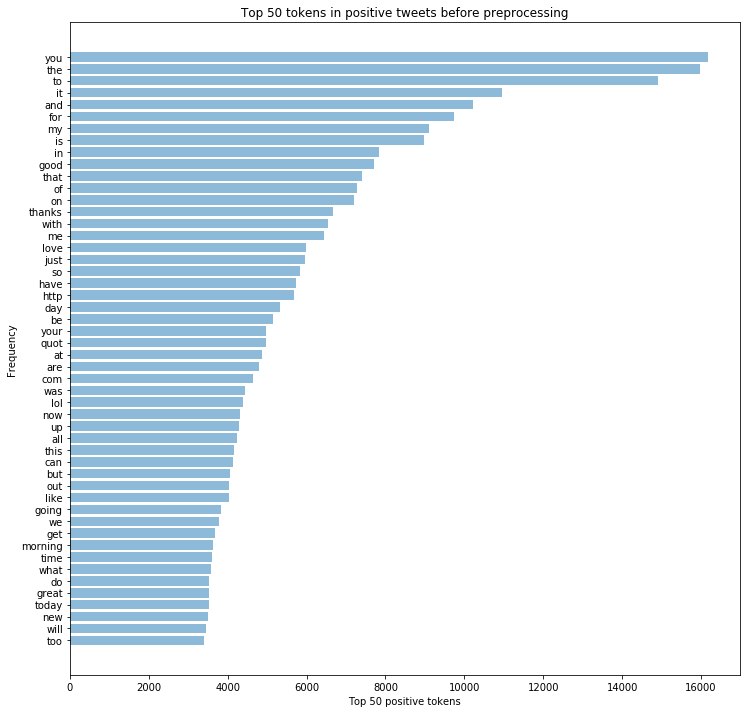

In [11]:
y_pos = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.yticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='horizontal')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets before preprocessing')
plt.gca().invert_yaxis()

Now let's conduct the preprocessing and have again a look at the most frequent words in positive and negative tweets and compare the results to the bar charts before the preprocessing.

In [12]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [13]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    #for tweet in textdata:
        #tweet = tweet.lower()
    tweet = textdata.lower()
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' ',tweet)#re.sub(urlPattern,' URL',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' ', tweet)#tweet = re.sub(userPattern,' USER', tweet)         
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # Checking if the word is a stopword.
        if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        # processedText.append(tweetwords)
        
    return tweetwords

In [14]:
#%%time
df.text = df.text.apply(lambda x: preprocess(x))

In [15]:
#%%time
vectorizer_prep = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer_prep.fit(df.text)
print('No. of feature_words: ', len(vectorizer_prep.get_feature_names()))
print(vectorizer_prep)

No. of feature_words:  500000
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)


In [16]:
#%%time

#Create matrices with word counts for neg and pos texts
neg_doc_matrix_prep = vectorizer_prep.transform(df[df.target == 'negative'].text)
pos_doc_matrix_prep = vectorizer_prep.transform(df[df.target == 'positive'].text)

#Create 2 lists with counts for each word in all neg and pos texts
neg_tf_prep = np.sum(neg_doc_matrix_prep, axis=0)
pos_tf_prep = np.sum(pos_doc_matrix_prep, axis=0)

#Convert neg and pos word count lists from from dim (1, 684358) to dim (684358,)
neg_prep = np.squeeze(np.asarray(neg_tf_prep))
pos_prep = np.squeeze(np.asarray(pos_tf_prep))

#Combine two arrays from neg and pos word counts to dataframe and add words as headers
term_freq_df_prep = pd.DataFrame([neg_prep,pos_prep], columns=vectorizer_prep.get_feature_names()).transpose()

term_freq_df_prep.columns = ['negative', 'positive']
term_freq_df_prep['total'] = term_freq_df_prep['negative'] + term_freq_df_prep['positive']

term_freq_df_prep.sort_values(by='total', ascending=False).iloc[0:10];

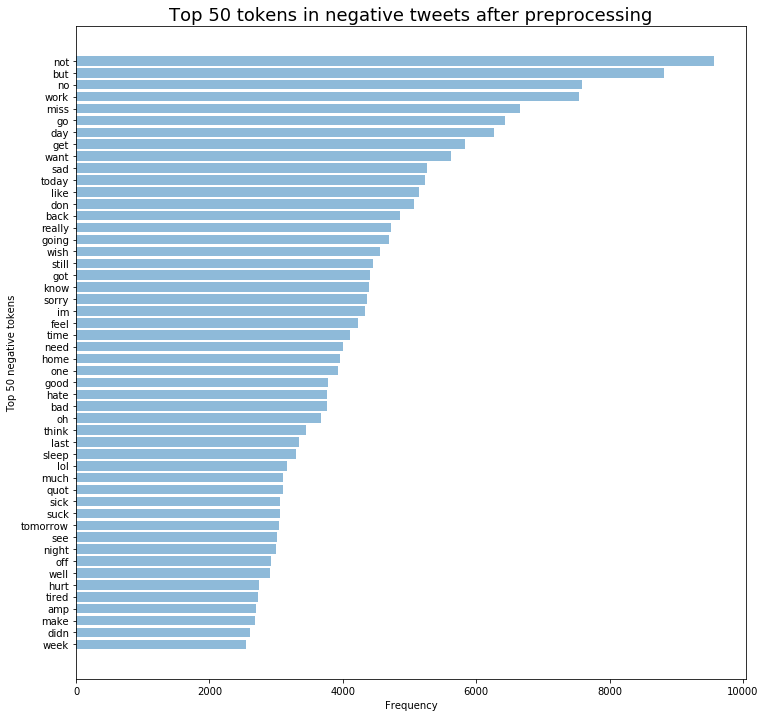

In [17]:
x_range = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(x_range, term_freq_df_prep.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.yticks(x_range, term_freq_df_prep.sort_values(by='negative', ascending=False)['negative'][:50].index, rotation='horizontal')
plt.xlabel('Frequency')
plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets after preprocessing', fontsize=18)
plt.gca().invert_yaxis()

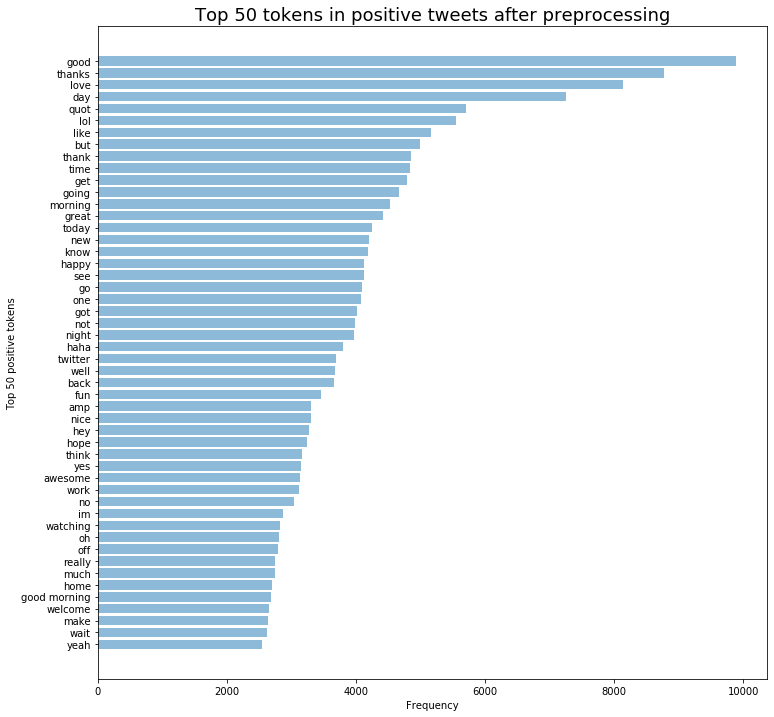

In [18]:
x_range = np.arange(50)
plt.figure(figsize=(12,12))
plt.barh(x_range, term_freq_df_prep.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.yticks(x_range, term_freq_df_prep.sort_values(by='positive', ascending=False)['positive'][:50].index, rotation='horizontal')
plt.xlabel('Frequency')
plt.ylabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets after preprocessing', fontsize=18)
plt.gca().invert_yaxis()

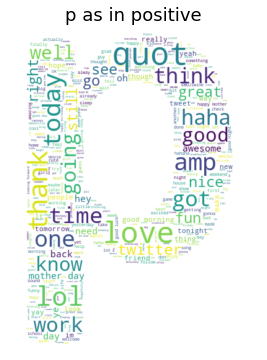

In [19]:
mask = np.array(Image.open('positive.PNG'))
plt.figure(figsize=(12, 6))
wc = WordCloud(mask=mask, background_color='white', max_words=2000, width=mask.shape[1], height=mask.shape[0]).generate(' '.join(df[df['target']=='positive'].iloc[0:200000].text))
plt.axis('off')
plt.title('p as in positive', fontsize=18)
plt.imshow(wc, interpolation='bilinear');

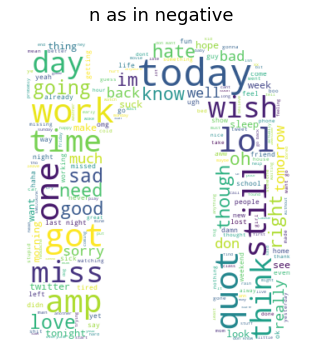

In [20]:
mask = np.array(Image.open('negative.PNG'))
plt.figure(figsize=(12, 6))
wc = WordCloud(mask=mask, background_color='white', max_words=2000, width=mask.shape[1], height=mask.shape[0]).generate(' '.join(df[df['target']=='negative'].iloc[0:200000].text))
plt.axis('off')
plt.title('n as in negative', fontsize=18)
plt.imshow(wc, interpolation='bilinear');

## 2. Modelling, Prediction and Evaluation

In this section a **Logistic Regression** classifier is trained and evaluated.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size = 0.2, random_state = 0)

In [22]:
#%%time
vectorizer_prep = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer_prep.fit(X_train)

print('No. of feature_words: ', len(vectorizer_prep.get_feature_names()))
print(vectorizer_prep)

No. of feature_words:  500000
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)


In [23]:
X_train = vectorizer_prep.transform(X_train)
X_test = vectorizer_prep.transform(X_test)

In [24]:
def evaluate_model(model):
    
    # predict values for test dataset
    y_pred = model.predict(X_test)
    
    # print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))
    
    # compute and plot the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['negative', 'positive']
    group_names = ['true neg', 'false pos', 'false neg', 'true pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    fig, ax = plt.subplots()
    
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
    
    ax.set(yticks=[0, 2], xticks=[0,1], xticklabels=categories, yticklabels=categories)
    ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))
    plt.xlabel('Predicted values', fontdict={'size':14})
    plt.ylabel('Actual values', fontdict={'size':14})
    plt.title('Confusion Matrix', fontdict={'size':18})

In [25]:
#%%time
LRmodel = LogisticRegression(C=2, solver='liblinear', max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

precision    recall  f1-score   support

    negative       0.82      0.80      0.81    159815
    positive       0.80      0.82      0.81    160185

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



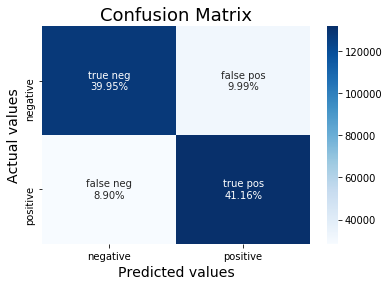

In [26]:
evaluate_model(LRmodel)

## Saving the Model

In [27]:
# Save the vectorizer model
file = open('vectorizer.pickle', 'wb')
pickle.dump(vectorizer_prep, file)
file.close()

# Save the logistic regression model
file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

## Conlusion
The bar charts before and after the preprocessing show the importance of these steps in NLP. The Logistic Regression classifier with accuracy rate of 81% shows good results compared to the benchmark on this dataset. Further steps could be to compare this Logistic Regression classifier to other classifiers, e.g. neural networks.